In [2]:
from cassandra.cluster import Cluster
import pandas as pd
import numpy as np

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler

In [3]:
class StockAnalysisSystem:
    def __init__(self, cassandra_host='127.0.0.1', cassandra_port=9042):
        self.cassandra_host = cassandra_host
        self.cassandra_port = cassandra_port
        self.scaler = MinMaxScaler()

# ตั้งค่า Parameter เบื้องต้น
CASSANDRA_HOST = '127.0.0.1'
CASSANDRA_PORT = 9042
SYMBOL = 'BTC' # หรือระบุชื่อหุ้นที่ต้องการ

print(f"System initialized for symbol: {SYMBOL}")

System initialized for symbol: BTC


In [4]:
def get_candlestick_data(symbol, cassandra_host, cassandra_port, limit=1000):
    cluster = Cluster([cassandra_host], port=cassandra_port)
    session = cluster.connect('data_stock')
    
    query = """
        SELECT symbol, time, open, high, low, close, volume, value 
        FROM candlestick_data 
        WHERE symbol = %s 
        LIMIT %s 
        ALLOW FILTERING
    """
    
    rows = session.execute(query, (symbol, limit))
    df = pd.DataFrame(list(rows))
    
    # แปลงเวลาและจัดเรียงข้อมูล
    df['time'] = pd.to_datetime(df['time'])
    df.sort_values('time', inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    cluster.shutdown()
    return df

print("Function get_candlestick_data is ready.")

Function get_candlestick_data is ready.


In [5]:
# ดึงข้อมูลมาเก็บในตัวแปร df
df = get_candlestick_data(SYMBOL, CASSANDRA_HOST, CASSANDRA_PORT)

# ตรวจสอบโครงสร้างข้อมูล
print("--- Data Info ---")
print(df.info())

print("\n--- Descriptive Statistics ---")
display(df.describe())

print("\n--- First 5 Rows ---")
display(df.head())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  729 non-null    object        
 1   time    729 non-null    datetime64[ns]
 2   open    729 non-null    float64       
 3   high    729 non-null    float64       
 4   low     729 non-null    float64       
 5   close   729 non-null    float64       
 6   volume  729 non-null    int64         
 7   value   729 non-null    float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 45.7+ KB
None

--- Descriptive Statistics ---


,time,open,high,low,close,volume,value
count,729,729.000000,729.000000,729.000000,729.000000,7.290000e+02,729.0
mean,2024-07-15 12:56:17.777777664,0.448505,0.459314,0.437997,0.446776,2.663634e+07,0.0
min,2023-01-17 00:00:00,0.260000,0.270000,0.260000,0.260000,3.935720e+05,0.0
25%,2023-10-16 00:00:00,0.370000,0.380000,0.360000,0.370000,5.242491e+06,0.0
50%,2024-07-16 00:00:00,0.440000,0.450000,0.430000,0.430000,1.090134e+07,0.0
75%,2025-04-11 00:00:00,0.520000,0.530000,0.510000,0.510000,2.652763e+07,0.0
max,2026-01-16 00:00:00,0.720000,0.740000,0.700000,0.720000,5.167988e+08,0.0
std,NaN,0.099998,0.102546,0.097481,0.099735,4.901904e+07,0.0



--- First 5 Rows ---


,symbol,time,open,high,low,close,volume,value
0,BTC,2023-01-17,0.50,0.50,0.49,0.49,17063512,0.0
1,BTC,2023-01-18,0.49,0.53,0.49,0.51,69799999,0.0
2,BTC,2023-01-19,0.51,0.51,0.49,0.49,22488547,0.0
3,BTC,2023-01-20,0.50,0.51,0.49,0.50,6123431,0.0
4,BTC,2023-01-23,0.52,0.54,0.51,0.51,63887312,0.0


In [6]:
def generate_hs_labels(df, window=5):
    """
    หา Head & Shoulders pattern พร้อมรายละเอียด
    - window: จำนวนแท่งเทียนรอบข้างที่ใช้ยืนยันจุด Peak
    """
    close_prices = df['close'].values
    labels = np.zeros(len(close_prices))
    
    # 1. หา local peaks (จุดสูงสุดในระยะ window)
    local_max_idx = []
    for i in range(window, len(close_prices) - window):
        is_peak = True
        for j in range(1, window + 1):
            if close_prices[i] <= close_prices[i-j] or close_prices[i] <= close_prices[i+j]:
                is_peak = False
                break
        if is_peak:
            local_max_idx.append(i)
    
    hs_patterns = []
    
    # 2. ตรวจสอบเงื่อนไข H&S pattern (3 peaks ต่อเนื่องกัน โดยอันกลางสูงที่สุด)
    for i in range(len(local_max_idx) - 2):
        ls_idx = local_max_idx[i]
        head_idx = local_max_idx[i + 1]
        rs_idx = local_max_idx[i + 2]
        
        ls_price = close_prices[ls_idx]
        head_price = close_prices[head_idx]
        rs_price = close_prices[rs_idx]
        
        # เงื่อนไข: Head สูงกว่าไหล่ทั้งสองข้าง และไหล่สองข้างมีราคาใกล้เคียงกัน (diff < 8%)
        if (head_price > ls_price and 
            head_price > rs_price and 
            ls_price > 0 and
            abs(ls_price - rs_price) / ls_price < 0.08):
            
            labels[ls_idx:rs_idx+1] = 1 # กำหนด Label เป็น 1 ในช่วงที่เกิด Pattern
            
            # หาจุดต่ำสุดระหว่างยอด (Neckline/Valleys)
            left_valley_idx = ls_idx + np.argmin(close_prices[ls_idx:head_idx+1])
            left_valley_price = close_prices[left_valley_idx]
            
            right_valley_idx = head_idx + np.argmin(close_prices[head_idx:rs_idx+1])
            right_valley_price = close_prices[right_valley_idx]
            
            hs_patterns.append({
                'left_shoulder': {'idx': ls_idx, 'price': ls_price},
                'head': {'idx': head_idx, 'price': head_price},
                'right_shoulder': {'idx': rs_idx, 'price': rs_price},
                'left_valley': {'idx': left_valley_idx, 'price': left_valley_price},
                'right_valley': {'idx': right_valley_idx, 'price': right_valley_price}
            })
    
    return labels, hs_patterns

print("Label generation function defined.")

Label generation function defined.


In [7]:
# สร้าง Labels และเก็บข้อมูลรูปแบบที่พบ
labels, patterns_found = generate_hs_labels(df)

# เพิ่ม Labels เข้าไปใน DataFrame หลัก
df['hs_label'] = labels

print(f"Total rows: {len(df)}")
print(f"Number of H&S patterns detected: {len(patterns_found)}")
print(f"Sample labels (first 20 values): {labels[:20]}")

# ตรวจสอบการกระจายตัวของ Class (Data Balance)
print("\nClass distribution:")
print(df['hs_label'].value_counts())

Total rows: 729
Number of H&S patterns detected: 3
Sample labels (first 20 values): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Class distribution:
hs_label
0.0    638
1.0     91
Name: count, dtype: int64


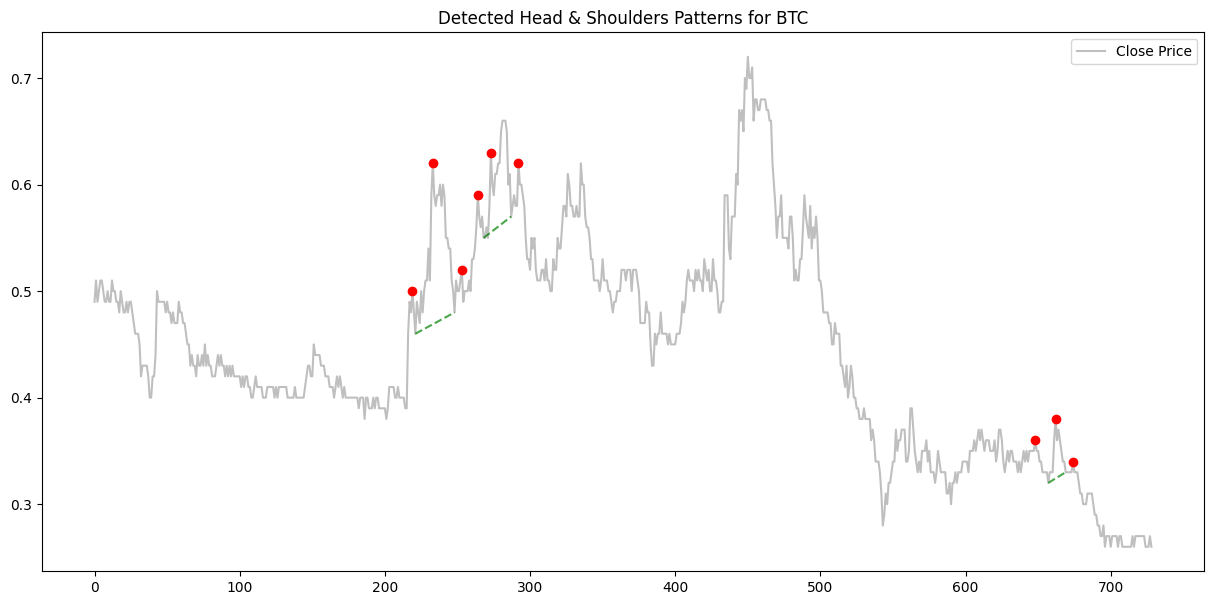

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(df['close'], label='Close Price', color='gray', alpha=0.5)

# ไฮไลท์จุดที่พบ Pattern
for p in patterns_found:
    plt.scatter([p['left_shoulder']['idx'], p['head']['idx'], p['right_shoulder']['idx']], 
                [p['left_shoulder']['price'], p['head']['price'], p['right_shoulder']['price']], 
                color='red', zorder=5)
    
    # วาดเส้น Neckline คร่าวๆ
    plt.plot([p['left_valley']['idx'], p['right_valley']['idx']], 
             [p['left_valley']['price'], p['right_valley']['price']], 
             'g--', alpha=0.7)

plt.title(f"Detected Head & Shoulders Patterns for {SYMBOL}")
plt.legend()
plt.show()

In [9]:
# เตรียมข้อมูล Close Price
close_prices = df['close'].values.reshape(-1, 1)

# เรียกใช้ Scaler จากระบบ (หรือสร้างใหม่หากรันแยก Cell)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
close_scaled = scaler.fit_transform(close_prices)

# กำหนด Parameter สำหรับ Sequence
seq_length = 30
forecast_days = 5

# สร้าง sequences (X: ข้อมูลย้อนหลัง 30 วัน, y: ราคาของวันถัดไป)
X, y = [], []
for i in range(len(close_scaled) - seq_length):
    X.append(close_scaled[i:i+seq_length])
    y.append(close_scaled[i+seq_length])

X, y = np.array(X), np.array(y)

# Train/Test Split (80/20)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (559, 30, 1)
X_test shape: (140, 30, 1)


In [10]:
from sklearn.utils import class_weight

# 1. สร้าง Labels
labels, hs_patterns = generate_hs_labels(df)

# 2. เลือก Features และทำ Scaling
features = df[['close', 'volume']].values
scaler_cnn = MinMaxScaler()
features_scaled = scaler_cnn.fit_transform(features)

# 3. สร้าง Sequences
seq_length = 30
X_cnn, y_cnn = [], []
for i in range(len(features_scaled) - seq_length):
    X_cnn.append(features_scaled[i:i+seq_length])
    y_cnn.append(labels[i+seq_length])

X_cnn, y_cnn = np.array(X_cnn), np.array(y_cnn)

# 4. Train/Test Split
split = int(len(X_cnn) * 0.8)
X_train_cnn, X_test_cnn = X_cnn[:split], X_cnn[split:]
y_train_cnn, y_test_cnn = y_cnn[:split], y_cnn[split:]

# --- ส่วนที่เพิ่มใหม่: คำนวณ Class Weights ---
# วิธีนี้จะบอกให้โมเดลรู้ว่า Pattern (1) สำคัญกว่าปกติ เพราะมีจำนวนน้อย
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_cnn),
    y=y_train_cnn
)
class_weights = dict(enumerate(weights))

print(f"CNN Input Shape: {X_train_cnn.shape}")
print(f"Pattern labels found: {sum(y_cnn)} from {len(y_cnn)} samples")
print(f"Class Weights applied: {class_weights}")

CNN Input Shape: (559, 30, 2)
Pattern labels found: 91.0 from 699 samples
Class Weights applied: {0: np.float64(0.5646464646464646), 1: np.float64(4.3671875)}


In [ ]:
# TensorFlow / Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM ,Dropout,Dense

# Build LSTM Model
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(loss='mse', optimizer='adam')

print("🧠 Training LSTM model...")
history = model_lstm.fit(
    X_train, y_train, 
    epochs=20, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1
)

🧠 Training LSTM model...
Epoch 1/20


/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0802 - val_loss: 0.0102
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0165 - val_loss: 0.0169
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0127 - val_loss: 0.0076
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0109 - val_loss: 0.0096
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0107 - val_loss: 0.0075
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0083 - val_loss: 0.0055
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0083 - val_loss: 0.0050
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073 - val_loss: 0.0046
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0072 - val_loss: 0.0053
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0071 - val_loss: 0.0044
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0074 - val_l

In [ ]:
# Scikit-learn

from sklearn.metrics import ( mean_absolute_error,mean_squared_error, r2_score)
# Predict
y_pred = model_lstm.predict(X_test, verbose=0)

# Inverse Transform เพื่อกลับมาเป็นค่าราคาสกุลเงินเดิม
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculate Metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mape = np.mean(np.abs((y_test_rescaled - y_pred_rescaled) / y_test_rescaled)) * 100
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Directional Accuracy (ความแม่นยำในการทายทิศทาง ขึ้น/ลง)
actual_direction = np.sign(np.diff(y_test_rescaled.flatten()))
pred_direction = np.sign(np.diff(y_pred_rescaled.flatten()))
directional_acc = np.mean(actual_direction == pred_direction) * 100

print(f"\n--- Model Performance Metrics ---")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2 Score: {r2:.4f}")
print(f"Directional Accuracy: {directional_acc:.2f}%")


--- Model Performance Metrics ---
MAE:  0.02
RMSE: 0.02
MAPE: 5.98%
R2 Score: 0.6500
Directional Accuracy: 25.18%


In [13]:
# ดึง 30 วันล่าสุดจากข้อมูล Scaled มาเป็นจุดเริ่มต้น
last_sequence = close_scaled[-seq_length:].reshape(1, seq_length, 1)
future_predictions = []

for _ in range(forecast_days):
    # ทายวันถัดไป
    next_pred = model_lstm.predict(last_sequence, verbose=0)
    future_predictions.append(next_pred[0, 0])
    
    # อัปเดต sequence โดยตัดตัวแรกออกและเพิ่มตัวที่ทายได้เข้าไปท้ายสุด
    last_sequence = np.append(last_sequence[:, 1:, :], 
                             next_pred.reshape(1, 1, 1), axis=1)

# แปลงราคากลับเป็นค่าปกติ
future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print(f"🚀 Forecasted prices for the next {forecast_days} days:")
for i, price in enumerate(future_prices.flatten(), 1):
    print(f"Day {i}: {price:.2f}")

🚀 Forecasted prices for the next 5 days:
Day 1: 0.28
Day 2: 0.29
Day 3: 0.29
Day 4: 0.29
Day 5: 0.29


In [ ]:

from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Build CNN Model (ปรับ Dropout เพิ่มขึ้นเป็น 0.5 เพื่อลด Overfit)
model_cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(seq_length, 2)),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=3, activation='relu'),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.5), # เพิ่มจาก 0.3 เป็น 0.5
    Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# --- ส่วนที่เพิ่มใหม่: Early Stopping ---
# หยุดเทรนถ้า Val Loss ไม่ดีขึ้นติดต่อกัน 3 รอบ และดึงค่าที่ดีที่สุดกลับมา
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)


print("🔍 Training CNN with Balanced Weights & Early Stopping...")
history_cnn = model_cnn.fit(
    X_train_cnn, y_train_cnn, 
    epochs=30, # เพิ่ม Epoch ได้เพราะมี Early Stopping คอยหยุดให้
    batch_size=32, 
    validation_split=0.1, 
    class_weight=class_weights, # ใส่ Class Weights ที่คำนวณไว้
    callbacks=[early_stop],      # ใส่ Early Stopping
    verbose=1
)





🔍 Training CNN with Balanced Weights & Early Stopping...
Epoch 1/30


/Users/hilmanyusoh/Desktop/stock_pattern/venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3062 - loss: 0.7213 - val_accuracy: 0.0000e+00 - val_loss: 0.7351
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1511 - loss: 0.6988 - val_accuracy: 0.0000e+00 - val_loss: 0.7276
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2346 - loss: 0.6829 - val_accuracy: 0.0000e+00 - val_loss: 0.7315
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4453 - loss: 0.6378 - val_accuracy: 0.3929 - val_loss: 0.7324
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6402 - loss: 0.6121 - val_accuracy: 0.4643 - val_loss: 0.7154
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6501 - loss: 0.5750 - val_accuracy: 0.4643 - val_loss: 0.7118
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7873 - loss: 0.5396 - val_accuracy: 0.5893 - val_loss: 0.6819
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8191 - loss: 0.5323 - val_accuracy: 0.5179 - val_los

In [15]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc,
                             )

# Predict probabilities
y_pred_prob = model_cnn.predict(X_test_cnn, verbose=0).flatten()
# แปลง Probability เป็น Class (0 หรือ 1) โดยใช้ Threshold 0.5
y_pred_cnn = (y_pred_prob > 0.5).astype(int)

# Calculate Metrics
accuracy = accuracy_score(y_test_cnn, y_pred_cnn)
precision = precision_score(y_test_cnn, y_pred_cnn, zero_division=0)
recall = recall_score(y_test_cnn, y_pred_cnn, zero_division=0)
f1 = f1_score(y_test_cnn, y_pred_cnn, zero_division=0)
cm = confusion_matrix(y_test_cnn, y_pred_cnn)

# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_test_cnn, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"--- CNN Pattern Recognition Metrics ---")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f} (พบ Pattern จริงๆ เท่าไหร่จากที่ทายไป)")
print(f"Recall:    {recall:.4f} (เก็บ Pattern ที่เกิดขึ้นจริงได้ครบไหม)")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

--- CNN Pattern Recognition Metrics ---
Accuracy:  0.7429
Precision: 0.3548 (พบ Pattern จริงๆ เท่าไหร่จากที่ทายไป)
Recall:    0.4074 (เก็บ Pattern ที่เกิดขึ้นจริงได้ครบไหม)
F1 Score:  0.3793
ROC AUC:   0.4762


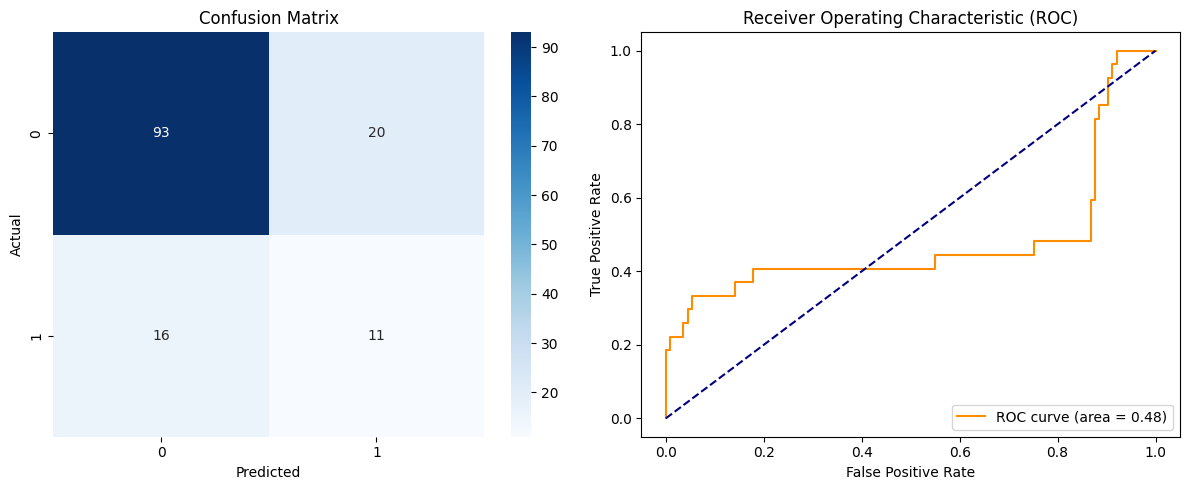

In [16]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Plot ROC Curve
ax[1].plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
ax[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
ax[1].set_title('Receiver Operating Characteristic (ROC)')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

In [38]:
# HuggingFace Transformers
from transformers import pipeline  

def analyze_sentiment(symbol, custom_news=None):
    """
    วิเคราะห์ sentiment จากข่าวด้วย DistilBERT
    - ให้ค่าเฉลี่ยคะแนนระหว่าง -1 (Negative) ถึง 1 (Positive)
    """
    if custom_news is None:
        # Mockup data สำหรับกรณีไม่มีข้อมูลข่าวจริง
        news_samples = {
            'ADVANC': [
                "ADVANC reports strong Q4 earnings, beating expectations",
                "5G rollout accelerates, ADVANC gains market share"
            ],
            'PTT': [
                "PTT stock rises on higher oil prices",
                "Energy sector outlook remains positive"
            ],
            'AOT': [
                "Airport traffic recovers strongly in tourism season",
                "AOT announces expansion plans"
            ]
        }
        texts = news_samples.get(symbol, [
            f"{symbol} maintains steady performance",
            "Market conditions remain favorable"
        ])
    else:
        texts = custom_news
    
    try:
        # โหลดโมเดลวิเคราะห์ความรู้สึก (ดาวน์โหลดอัตโนมัติในการรันครั้งแรก)
        classifier = pipeline("sentiment-analysis", 
                            model="distilbert-base-uncased-finetuned-sst-2-english")
        results = classifier(texts)
        
        sentiment_scores = []
        for r in results:
            # แปลง Label เป็นตัวเลข: Positive เป็นค่าบวก, Negative เป็นค่าลบ
            score = r['score'] if r['label'] == 'POSITIVE' else -r['score']
            sentiment_scores.append(score)
        
        avg_sentiment = np.mean(sentiment_scores)
        
        # ตัดสินใจ Signal ตามเกณฑ์ Threshold
        if avg_sentiment > 0.1:
            signal = 'POSITIVE'
        elif avg_sentiment < -0.1:
            signal = 'NEGATIVE'
        else:
            signal = 'NEUTRAL'
            
        return {
            'details': results,
            'average_score': avg_sentiment,
            'signal': signal
        }
    except Exception as e:
        print(f"⚠️ Sentiment analysis error: {e}")
        return {
            'details': [],
            'average_score': 0.0,
            'signal': 'NEUTRAL'
        }

print("Sentiment Analysis function is ready.")



Sentiment Analysis function is ready.


In [35]:
# รันการวิเคราะห์
sentiment_result = analyze_sentiment(SYMBOL)

print(f"--- Sentiment Analysis Result for {SYMBOL} ---")
print(f"Average Score: {sentiment_result['average_score']:.4f}")
print(f"Market Signal: {sentiment_result['signal']}")
print("\nDetail Breakdown:")
for i, detail in enumerate(sentiment_result['details']):
    print(f"News {i+1}: {detail['label']} (Score: {detail['score']:.4f})")

⚠️ Sentiment analysis error: name 'torch' is not defined
--- Sentiment Analysis Result for BTC ---
Average Score: 0.0000
Market Signal: NEUTRAL

Detail Breakdown:
